# 0) Работа с Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 1) Подключение библиотек

In [ ]:
import os
from datetime import datetime
now = datetime.now()
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import cv2

!pip install pytelegrambotapi
import telebot
import requests
import shutil

!pip install pyspellchecker
from spellchecker import SpellChecker

     |████████████████████████████████| 102 kB 14.8 MB/s 
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.1.1-py3-none-any.whl size=80779 sha256=5ef67f5126f35e1708de3b12f7c46871a6563205fe9b6e349bb2c845690539bf
  Stored in directory: /root/.cache/pip/wheels/00/9d/f5/f589ebef11a6541a4e5a1793a380db577bab5583eac6b45514
Successfully built pytelegrambotapi
     |████████████████████████████████| 2.7 MB 12.9 MB/s 


# 2) Инициализация необходимых переменных

**Пути до нужных файлов и директорий**

In [ ]:
DATADIR_imgs = '/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10/Uploaded_Images'
PATH_to_model = '/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10'

**Словарь для интерпритации результатов предсказания Нейронной Сети**

In [ ]:
values = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 
          'п','р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
nums = range(0, 33)

interpritation_dict = dict(zip(nums, values))

interpritation_dict

{0: 'а',
 1: 'б',
 2: 'в',
 3: 'г',
 4: 'д',
 5: 'е',
 6: 'ё',
 7: 'ж',
 8: 'з',
 9: 'и',
 10: 'й',
 11: 'к',
 12: 'л',
 13: 'м',
 14: 'н',
 15: 'о',
 16: 'п',
 17: 'р',
 18: 'с',
 19: 'т',
 20: 'у',
 21: 'ф',
 22: 'х',
 23: 'ц',
 24: 'ч',
 25: 'ш',
 26: 'щ',
 27: 'ъ',
 28: 'ы',
 29: 'ь',
 30: 'э',
 31: 'ю',
 32: 'я'}

**Движок для проверки офрографии**

In [ ]:
orthography_engine = SpellChecker(language = "ru")

**Бот**

In [ ]:
API_TOKEN = "<API TOKEN>"
bot = telebot.TeleBot(API_TOKEN)

**Нейронная сеть**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvNet_V2(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (7,7)) #26x26
        # Activation Function (ReLU)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (5, 5)) #22x22
        # Activation Function (ReLU)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3)) #20x20
        self.pool = nn.MaxPool2d(kernel_size = (2, 2)) #10x10
        # Activation Function (ReLU)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3)) #8x8
        # Activation Function (ReLU)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 8 * 256, 256)
        # Sigmoid Function
        self.fc2 = nn.Linear(256, 33)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))

        x = self.flatten(x)
        x = F.sigmoid(self.fc1(x))

        x  = self.fc2(x)

        return x

model = ConvNet_V2()
model = model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10/main_nn_model"))
model.eval()

ConvNet_V2(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=33, bias=True)
)

# 3) Структура Telegram Бота

In [ ]:
@bot.message_handler(commands = ["start"])
def start_message(message):
	bot.reply_to(message, "Приветствую! Я Начинаю работу!")

@bot.message_handler(commands = ["help"])
def help_message(message):
  documentation_text = "Проект Карманный помощник Учителя. \n \nДанный бот предназначен для упрощения работы учителя, а именно проверки тетрадей учеников по Русскому языку и Литературе. \n \nГлавными функциями программы являются: Детекция (обнаружение) текста на фото, распознавание найденного текста, проверка на наличие орфографических ошибок и их исправление, а также антиплагиат, в виде проверки сочинений на списывание. \n \nПроект разработан за 2 недели, с нуля, командой старшеклассников. По этой причине просим не судить строго наш проект и не полагаться на него как на идеально точный продукт. Этот бот создан для ПЕРЕПРОВЕРКИ себя, но не для полноценной оценки работ. \n \nНаш бот постоянно обучается, поэтому, будьте добры, отвечать на вопросы об корректности выданного результата. \n \nДля получения инструкций по работе с Карманным помощником Учителя напишите и отправьте сообщение следующего содержания: /rules"
  bot.reply_to(message, documentation_text)

@bot.message_handler(commands = ["rules"])
def rules_message(message):
  rules_text = "Для получения корректных результатов вы должны строго действовать следующей инструкции: \n \n0) Обязательно выполняйте все действия по порядку; \n \n1) Делайте качественные фотографии; \n \n2) Начало текста должно обязательно находиться в левой – верхней части фотографии, а его последняя часть, в конце фото; \n \n3) Следуйте примеру: "
  bot.reply_to(message, rules_text)
  example_photo = open("/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10/Uploaded_Images/example_image.jpg", 'rb')
  bot.send_photo(message.chat.id, example_photo)
  bot.reply_to(message, "Для того что бы начать работу. Напишите (числом) количество букв в тексте, который вы хотите отправить. Это нужно для правильной работы бота.")

@bot.message_handler(content_types=["text"])
def get_count(message):
  global letters_count
  letters_count = int(message.text)
  bot.reply_to(message, "Количество букв принял. Спасибо. Отправьте фотографию.")

@bot.message_handler(content_types=["photo"])
def image_prediction(message):

    file_info = bot.get_file(message.photo[-1].file_id)
    bot.reply_to(message, "Принял вашу фотографию. Начинаю обработку.")
    letter_count = letters_count

    url = 'https://api.telegram.org/file/bot{0}/{1}'.format(API_TOKEN, file_info.file_path)
    response = requests.get(url, stream=True)

    got_image_time = now.strftime("%H_%M_%S")
    path = f"/content/drive/MyDrive/Projects_Main/Проект 18.10 - 29.10/Uploaded_Images/{got_image_time}_image.jpg"
    if response.status_code == 200:
        with open(path, 'wb') as f:
            response.raw.decode_content = True
            shutil.copyfileobj(response.raw, f)
    
    if letters_count >= 8 or letters_count <= 2:
      image_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      cropped_image = image_array
    else:
      image_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
      image_array = cv2.resize(image_array, (500, 500))

      cropped_image = image_array[5:400, 5:image_array.shape[1]]

    plt.imshow(cropped_image, cmap = "gray")
    plt.show()

    cropped_letters = []
    x1_coord = 0
    x2_coord = 80

    for letter in range(letter_count):
      letter_cropped = cropped_image[0:cropped_image.shape[0], x1_coord:x2_coord]
      letter_cropped = letter_cropped[40:cropped_image.shape[0], 10:80]
      x2_coord += 80
      x1_coord += 80
      plt.imshow(letter_cropped, cmap = "gray")
      plt.show()

      cropped_letters.append(letter_cropped)

    word = []

    for letter in cropped_letters:
      letter_cropped = cv2.resize(letter, (32, 32))

      plt.imshow(letter_cropped, cmap = "gray")
      plt.show()
  
      letter_cropped = letter_cropped / 255

      letter_cropped = torch.FloatTensor(letter_cropped.reshape((1, 32, 32)))
      letter_cropped = letter_cropped.unsqueeze(0)
      letter_cropped = letter_cropped.to(device)

      prediction = model(letter_cropped)

      predicted_num = np.argmax(prediction.data.cpu().numpy())
      predicted_letter = interpritation_dict.get(predicted_num)
      word.append(predicted_letter)

    result = ''.join(word)

    word = []
    cropped_letters = []
    letter_count = 0

    bot.reply_to(message, f'Текст на фото: {result}; Текст с исправленными ошибками: {orthography_engine.correction(result)}')


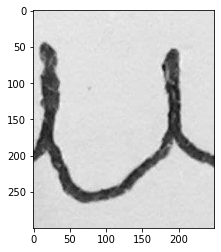

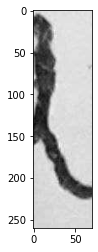

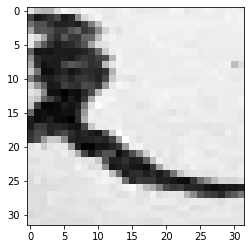

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2021-10-27 15:01:46,692 (__init__.py:600 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
2021-10-27 15:01:46,699 (__init__.py:602 MainThread) ERROR - TeleBot: "Break infinity polling"


In [ ]:
bot.infinity_polling()